# Resultados da Análise Topológica da RIMM
Rede de Interação microRNA-RNA mensageiro (RIMM)

# Importação de Bibliotecas

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Constantes

## Pastas de Dados

In [2]:
# Caminho da pasta raiz de dados
DATA_PATH = Path.cwd().parent / 'data'

# Caminho da pasta de dados processados
PROCESSED_DATA_PATH = DATA_PATH / 'processed'

# Caminho da pasta de dados resultantes da análise topológica
ANALYSIS_DATA_PATH = PROCESSED_DATA_PATH / 'topology-analysis'

# Caminho da pasta de dados resultantes da análise da rede bipartida
NETWORK_DATA_PATH = ANALYSIS_DATA_PATH / 'bipartite-network'

## Pastas de Imagens

In [3]:
# Caminho da pasta raiz de imagens
IMAGES_PATH = Path.cwd().parent / 'images'

# Caminho da pasta de imagens da rede bipartida
NETWORK_IMAGES_PATH = IMAGES_PATH / 'bipartite-network'

# Carregamento de Dados

In [4]:
# Lê o arquivo com os resultados da centralidade de intermediação
df_betweenness = pd.read_csv(
    filepath_or_buffer=Path(NETWORK_DATA_PATH / 'betweenness-centrality.csv')
)

# Lê o arquivo com os resultados das pontes
df_bridges = pd.read_csv(
    filepath_or_buffer=Path(NETWORK_DATA_PATH / 'bridges.csv')
)

# Lê o arquivo com os resultados da centralidade de proximidade
df_closeness = pd.read_csv(
    filepath_or_buffer=Path(NETWORK_DATA_PATH / 'closeness-centrality.csv')
)

# Lê o arquivo com os resultados da centralidade de grau
df_degree = pd.read_csv(
    filepath_or_buffer=Path(NETWORK_DATA_PATH / 'degree-centrality.csv')
)

# Análise dos Resultados

## Centralidade Grau

### Distribuição

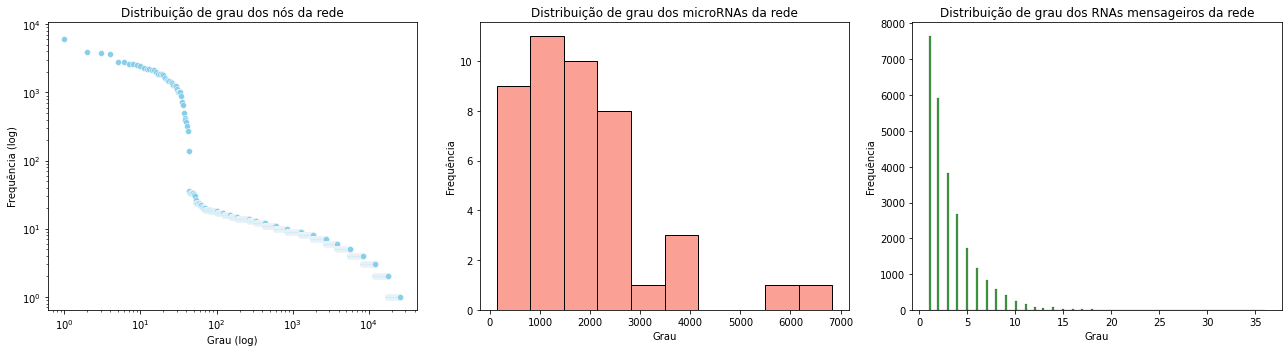

In [5]:
# Cria o subplot para três figuras em uma linha
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plota a distribuição log-log de grau dos nós
sns.scatterplot(data=df_degree['degree'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribuição de grau dos nós da rede')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Grau (log)')
axes[0].set_ylabel('Frequência (log)')

# Plota a distribuição de grau dos microRNAs
filter = df_degree['molecule'].str.startswith('hsa')
sns.histplot(data=df_degree[filter]['degree'], ax=axes[1], color='salmon')
axes[1].set_title('Distribuição de grau dos microRNAs da rede')
axes[1].set_xlabel('Grau')
axes[1].set_ylabel('Frequência')

# Plota a distribuição de grau dos RNAs mensageiros
sns.histplot(data=df_degree[~filter]['degree'], ax=axes[2], color='green')
axes[2].set_title('Distribuição de grau dos RNAs mensageiros da rede')
axes[2].set_xlabel('Grau')
axes[2].set_ylabel('Frequência')

# Salva a figura
plt.tight_layout()
fig.savefig(fname=NETWORK_IMAGES_PATH / 'degree-centrality-distribution.png', dpi=300)

# Exibe o subplot
plt.show()

### Estatísticas Descritivas

In [6]:
# Calcula as estatísticas da centralidade de grau da rede
df_degree['degree'].describe()

count    25677.000000
mean         6.377536
std         95.453544
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       6838.000000
Name: degree, dtype: float64

In [7]:
# Calcula as estatísticas da centralidade de grau dos microRNAs
filter = df_degree['molecule'].str.startswith('hsa')
df_degree[filter]['degree'].describe()

count      44.000000
mean     1860.863636
std      1382.451422
min       136.000000
25%       997.750000
50%      1579.500000
75%      2312.000000
max      6838.000000
Name: degree, dtype: float64

In [8]:
# Calcula as estatísticas da centralidade de grau dos RNAs mensageiros
filter = ~df_degree['molecule'].str.startswith('hsa')
df_degree[filter]['degree'].describe()

count    25633.000000
mean         3.194242
std          2.667631
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         36.000000
Name: degree, dtype: float64

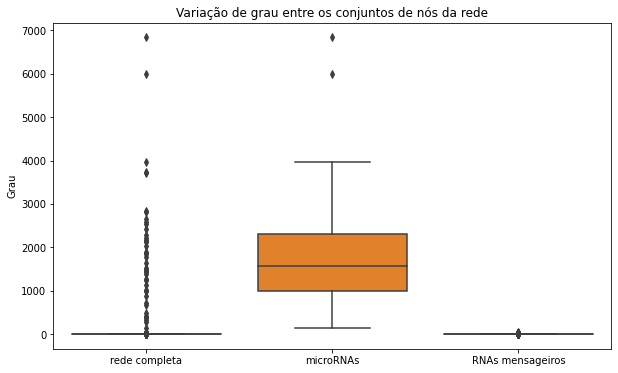

In [ ]:
# Separa os graus em três DataFrames distintos
filter = df_degree['molecule'].str.startswith('hsa')
df_network_degree = df_degree.copy()
df_mirna_degree = df_degree[filter].copy()
df_mrna_degree = df_degree[~filter].copy()

# Adiciona uma coluna de identificação nos DataFrames
df_network_degree['node_set'] = 'rede completa'
df_mirna_degree['node_set'] = 'microRNAs'
df_mrna_degree['node_set'] = 'RNAs mensageiros'

# Concatena os dados em um único DataFrame
df_boxplot_degree = pd.concat([df_network_degree, df_mirna_degree, df_mrna_degree])

# Plota a figura
plt.figure(figsize=(10, 6))
sns.boxplot(x='node_set', y='degree', data=df_boxplot_degree)
plt.title('Variação de grau entre os conjuntos de nós da rede')
plt.xlabel('')
plt.ylabel('Grau')

# Salva a figura
plt.savefig(fname=NETWORK_IMAGES_PATH / 'degree-centrality-boxplots.png', dpi=300)

# Exibe a figura
plt.show()

### Top-5 Moléculas

In [10]:
# Filtra o top-5 de microRNAs conforme a centralidade de grau
filter = df_degree['molecule'].str.startswith('hsa')
df_degree[filter].head()

,molecule,degree
0,hsa-miR-665,6838.0
1,hsa-miR-485-5p,5999.0
2,hsa-miR-381-3p,3967.0
3,hsa-miR-370-3p,3732.0
4,hsa-miR-493-5p,3704.0


In [11]:
# Filtra o top-10 de RNAs mensageiros conforme a centralidade de grau
filter = ~df_degree['molecule'].str.startswith('hsa')
df_degree[filter].head()

,molecule,degree
44,NM_001164344,36.0
45,NM_001393393,34.0
46,NM_015642,34.0
47,NM_001164345,33.0
48,NM_001348800,33.0


## Centralidade de Intermediação

### Distribuição

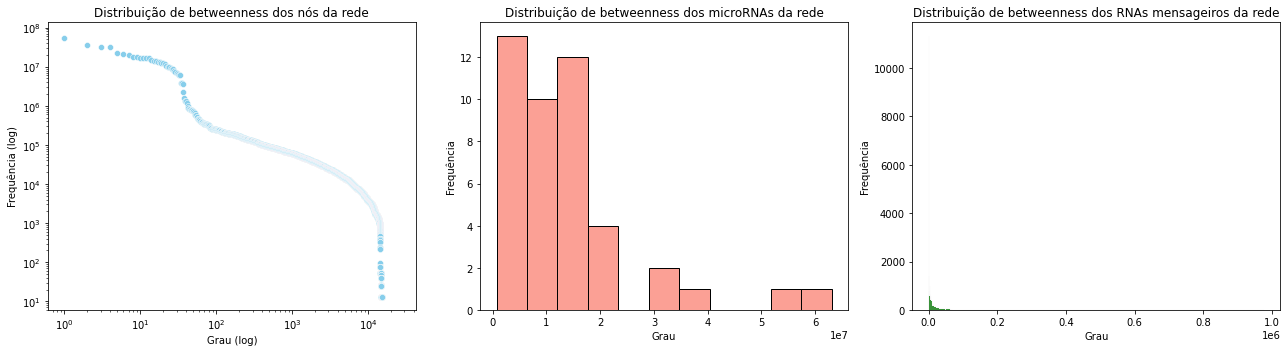

In [12]:
# Cria o subplot para três figuras em uma linha
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plota a distribuição de betweenness dos nós
sns.scatterplot(data=df_betweenness['betweenness'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribuição de betweenness dos nós da rede')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Grau (log)')
axes[0].set_ylabel('Frequência (log)')

# Plota a distribuição de betweenness dos microRNAs
filter = df_betweenness['molecule'].str.startswith('hsa')
sns.histplot(data=df_betweenness[filter]['betweenness'], ax=axes[1], color='salmon')
axes[1].set_title('Distribuição de betweenness dos microRNAs da rede')
axes[1].set_xlabel('Grau')
axes[1].set_ylabel('Frequência')

# Plota a distribuição de betweenness dos RNAs mensageiros
sns.histplot(data=df_betweenness[~filter]['betweenness'], ax=axes[2], color='green')
axes[2].set_title('Distribuição de betweenness dos RNAs mensageiros da rede')
axes[2].set_xlabel('Grau')
axes[2].set_ylabel('Frequência')

# Salva a figura
plt.tight_layout()
fig.savefig(fname=NETWORK_IMAGES_PATH / 'betweenness-centrality-distribution.png', dpi=300)

# Exibe o subplot
plt.show()

### Estatísticas Descritivas

In [13]:
# Calcula as estatísticas da centralidade de intermediação da rede
df_betweenness['betweenness'].describe()

count    2.567700e+04
mean     3.436353e+04
std      7.771582e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.634804e+03
75%      9.434221e+03
max      6.302994e+07
Name: betweenness, dtype: float64

In [14]:
# Calcula as estatísticas da centralidade de intermediação dos microRNAs
filter = df_betweenness['molecule'].str.startswith('hsa')
df_betweenness[filter]['betweenness'].describe()

count    4.400000e+01
mean     1.375982e+07
std      1.292261e+07
min      7.327850e+05
25%      6.229237e+06
50%      1.103220e+07
75%      1.673632e+07
max      6.302994e+07
Name: betweenness, dtype: float64

In [15]:
# Calcula as estatísticas da centralidade de intermediação dos RNAs mensageiros
filter = ~df_betweenness['molecule'].str.startswith('hsa')
df_betweenness[filter]['betweenness'].describe()

count     25633.000000
mean      10803.276284
std       30355.171872
min           0.000000
25%           0.000000
50%        1623.571399
75%        9334.969361
max      975994.166303
Name: betweenness, dtype: float64

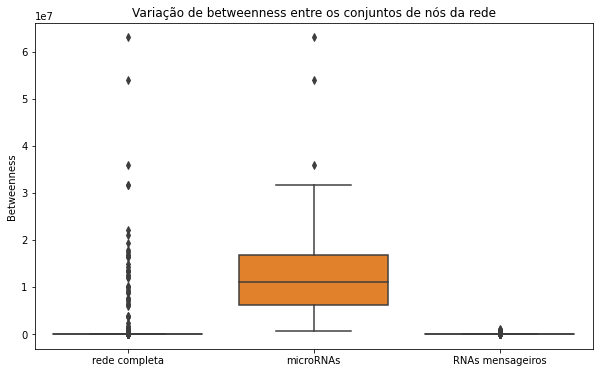

In [ ]:
# Separa os betweenness em três DataFrames distintos
filter = df_betweenness['molecule'].str.startswith('hsa')
df_network_betweenness = df_betweenness.copy()
df_mirna_betweenness = df_betweenness[filter].copy()
df_mrna_betweenness = df_betweenness[~filter].copy()

# Adiciona uma coluna de identificação nos DataFrames
df_network_betweenness['node_set'] = 'rede completa'
df_mirna_betweenness['node_set'] = 'microRNAs'
df_mrna_betweenness['node_set'] = 'RNAs mensageiros'

# Concatena os dados em um único DataFrame
df_boxplot_betweenness = pd.concat(
    [df_network_betweenness, df_mirna_betweenness, df_mrna_betweenness]
)

# Plota a figura
plt.figure(figsize=(10, 6))
sns.boxplot(x='node_set', y='betweenness', data=df_boxplot_betweenness)
plt.title('Variação de betweenness entre os conjuntos de nós da rede')
plt.xlabel('')
plt.ylabel('Betweenness')

# Salva a figura
plt.savefig(fname=NETWORK_IMAGES_PATH / 'betweenness-centrality-boxplots.png', dpi=300)

# Exibe a figura
plt.show()

### Top-5 Moléculas

In [17]:
# Filtra o top-5 de microRNAs conforme a centralidade de intermediação
filter = df_betweenness['molecule'].str.startswith('hsa')
df_betweenness[filter].head()

,molecule,betweenness
0,hsa-miR-665,6.302994e+07
1,hsa-miR-485-5p,5.395104e+07
2,hsa-miR-381-3p,3.588385e+07
3,hsa-miR-370-3p,3.169784e+07
4,hsa-miR-493-5p,3.167437e+07


In [18]:
# Filtra o top-10 de RNAs mensageiros conforme a centralidade de intermediação
filter = ~df_betweenness['molecule'].str.startswith('hsa')
df_betweenness[filter].head()

,molecule,betweenness
42,NM_001164344,975994.166303
44,NM_001393393,839142.497880
45,NM_015642,832099.967871
46,NM_001348800,785280.170440
47,NM_001348803,785280.170440


## Centralidade de Proximidade

### Distribuição

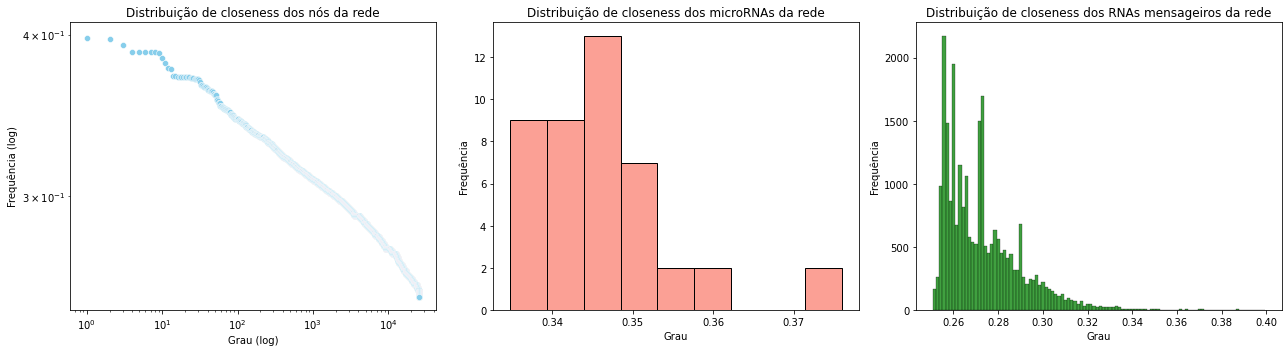

In [19]:
# Cria o subplot para três figuras em uma linha
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plota a distribuição de closeness dos nós
sns.scatterplot(data=df_closeness['closeness'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribuição de closeness dos nós da rede')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Grau (log)')
axes[0].set_ylabel('Frequência (log)')

# Plota a distribuição de closeness dos microRNAs
filter = df_closeness['molecule'].str.startswith('hsa')
sns.histplot(data=df_closeness[filter]['closeness'], ax=axes[1], color='salmon')
axes[1].set_title('Distribuição de closeness dos microRNAs da rede')
axes[1].set_xlabel('Grau')
axes[1].set_ylabel('Frequência')

# Plota a distribuição de closeness dos RNAs mensageiros
sns.histplot(data=df_closeness[~filter]['closeness'], ax=axes[2], color='green')
axes[2].set_title('Distribuição de closeness dos RNAs mensageiros da rede')
axes[2].set_xlabel('Grau')
axes[2].set_ylabel('Frequência')

# Salva a figura
plt.tight_layout()
fig.savefig(fname=NETWORK_IMAGES_PATH / 'closeness-centrality-distribution.png', dpi=300)

# Exibe o subplot
plt.show()

### Estatísticas Descritivas

In [20]:
# Calcula as estatísticas da centralidade de proximidade da rede
df_closeness['closeness'].describe()

count    25677.000000
mean         0.272970
std          0.017114
min          0.250772
25%          0.259957
50%          0.269836
75%          0.281153
max          0.399403
Name: closeness, dtype: float64

In [21]:
# Calcula as estatísticas da centralidade de proximidade dos microRNAs
filter = df_closeness['molecule'].str.startswith('hsa')
df_closeness[filter]['closeness'].describe()

count    44.000000
mean      0.346152
std       0.008713
min       0.334702
25%       0.341121
50%       0.344432
75%       0.349878
max       0.375990
Name: closeness, dtype: float64

In [22]:
# Calcula as estatísticas da centralidade de proximidade dos RNAs mensageiros
filter = ~df_closeness['molecule'].str.startswith('hsa')
df_closeness[filter]['closeness'].describe()

count    25633.000000
mean         0.272845
std          0.016854
min          0.250772
25%          0.259957
50%          0.269819
75%          0.281147
max          0.399403
Name: closeness, dtype: float64

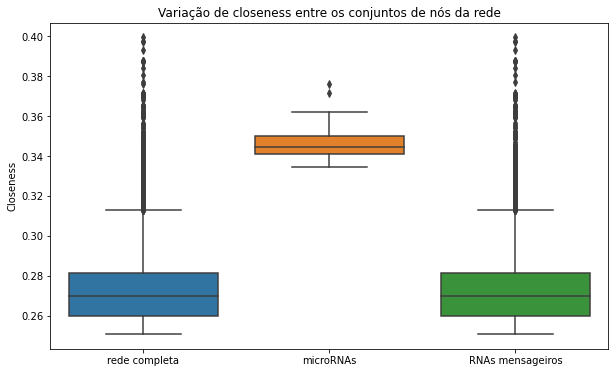

In [ ]:
# Separa os closeness em três DataFrames distintos
filter = df_closeness['molecule'].str.startswith('hsa')
df_network_closeness = df_closeness.copy()
df_mirna_closeness = df_closeness[filter].copy()
df_mrna_closeness = df_closeness[~filter].copy()

# Adiciona uma coluna de identificação nos DataFrames
df_network_closeness['node_set'] = 'rede completa'
df_mirna_closeness['node_set'] = 'microRNAs'
df_mrna_closeness['node_set'] = 'RNAs mensageiros'

# Concatena os dados em um único DataFrame
df_boxplot_closeness = pd.concat(
    [df_network_closeness, df_mirna_closeness, df_mrna_closeness]
)

# Plota a figura
plt.figure(figsize=(10, 6))
sns.boxplot(x='node_set', y='closeness', data=df_boxplot_closeness)
plt.title('Variação de closeness entre os conjuntos de nós da rede')
plt.xlabel('')
plt.ylabel('Closeness')

# Salva a figura
plt.savefig(fname=NETWORK_IMAGES_PATH / 'closeness-centrality-boxplots.png', dpi=300)

# Exibe a figura
plt.show()

### Top-5 Moléculas

In [24]:
# Filtra o top-5 de microRNAs conforme a centralidade de proximidade
filter = df_closeness['molecule'].str.startswith('hsa')
df_closeness[filter].head()

,molecule,closeness
13,hsa-miR-665,0.375990
15,hsa-miR-485-5p,0.371508
42,hsa-miR-381-3p,0.362139
48,hsa-miR-493-5p,0.359986
54,hsa-miR-370-3p,0.355865


In [25]:
# Filtra o top-10 de microRNAs conforme a centralidade de proximidade
filter = ~df_closeness['molecule'].str.startswith('hsa')
df_closeness[filter].head()

,molecule,closeness
0,NM_015642,0.399403
1,NM_001164345,0.397880
2,NM_005578,0.397142
3,NM_001164344,0.392984
4,NM_001164346,0.387785
